# Building a question answering system for Netflix titles using LLMs

This notebook presents an analysis of a Netflix dataset using a question answering (QA) system. The system uses pre-trained language models to generate answers to various questions about movies and TV shows available on Netflix. The evaluation includes assessing the accuracy of the generated answers and comparing them to the actual data. The question answering system aims to enhance user experience and to improve customer support.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from transformers import pipeline
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

#### Import and pre-process the data

In [2]:
netflix_df  = pd.read_excel('C:/Users/israel/Downloads/netflix_titles.xlsx')

# Adjust the column names and convert all columns to strings
netflix_df.columns = [col.replace("_", " ").capitalize() for col in netflix_df.columns]
netflix_df = netflix_df.astype(str)

# Prepare data text for the QA model - join columns into a single string
def format_data(row):
    formatted_text = ""
    for col_name, col_value in row.items():
        formatted_text += f"{col_name}: {col_value}. "
    return formatted_text.strip()
netflix_df['joined_text'] = netflix_df.apply(format_data, axis=1)

netflix_df = netflix_df.sample(frac=1.0, random_state=42)
netflix_df = netflix_df[:200]
netflix_df[:5]

,Show id,Type,Title,Director,Cast,Country,Date added,Release year,Rating,Duration,Listed in,Description,joined_text
4970,s4971,Movie,"Game Over, Man!",Kyle Newacheck,"Adam DeVine, Anders Holm, Blake Anderson, Utka...",United States,"March 23, 2018",2018,TV-MA,102 min,"Action & Adventure, Comedies",Three buddies with big dreams go from underach...,"Show id: s4971. Type: Movie. Title: Game Over,..."
3362,s3363,Movie,Arsenio Hall: Smart & Classy,Brian Volk-Weiss,Arsenio Hall,United States,"October 29, 2019",2019,TV-MA,63 min,Stand-Up Comedy,"In his first stand-up special, Arsenio Hall di...",Show id: s3363. Type: Movie. Title: Arsenio Ha...
5494,s5495,TV Show,Kazoops!,nan,"Reece Pockney, Scott Langley, Alex Babic, Gemm...",Australia,"May 5, 2017",2017,TV-Y,3 Seasons,Kids' TV,Music meets imagination in this inventive anim...,Show id: s5495. Type: TV Show. Title: Kazoops!...
1688,s1689,TV Show,We Are the Champions,nan,nan,United States,"November 17, 2020",2020,TV-MA,1 Season,"Docuseries, Reality TV","Explore an array of unique competitions, from ...",Show id: s1689. Type: TV Show. Title: We Are t...
1349,s1350,TV Show,"Pablo Escobar, el patrÃ³n del mal",nan,"AndrÃ©s Parra, Angie Cepeda, Cecilia Navia, Vi...",Colombia,"February 3, 2021",2012,TV-MA,1 Season,"Crime TV Shows, International TV Shows, Spanis...",From his days as a petty thief to becoming hea...,Show id: s1350. Type: TV Show. Title: Pablo Es...


### EDA

##### Distribution of movies and TV shows

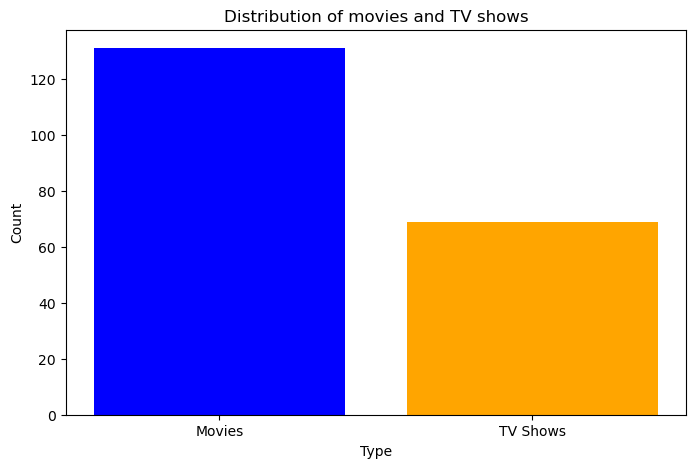

In [3]:
movie_counts = netflix_df[netflix_df['Type'] == 'Movie']['Type'].value_counts()
tv_counts = netflix_df[netflix_df['Type'] == 'TV Show']['Type'].value_counts()

plt.figure(figsize=(8, 5))
plt.bar(['Movies', 'TV Shows'], [movie_counts[0], tv_counts[0]], color=['blue', 'orange'])
plt.title('Distribution of movies and TV shows')
plt.xlabel('Type')
plt.ylabel('Count')
plt.show()

##### Distribution of release years for movies and TV shows

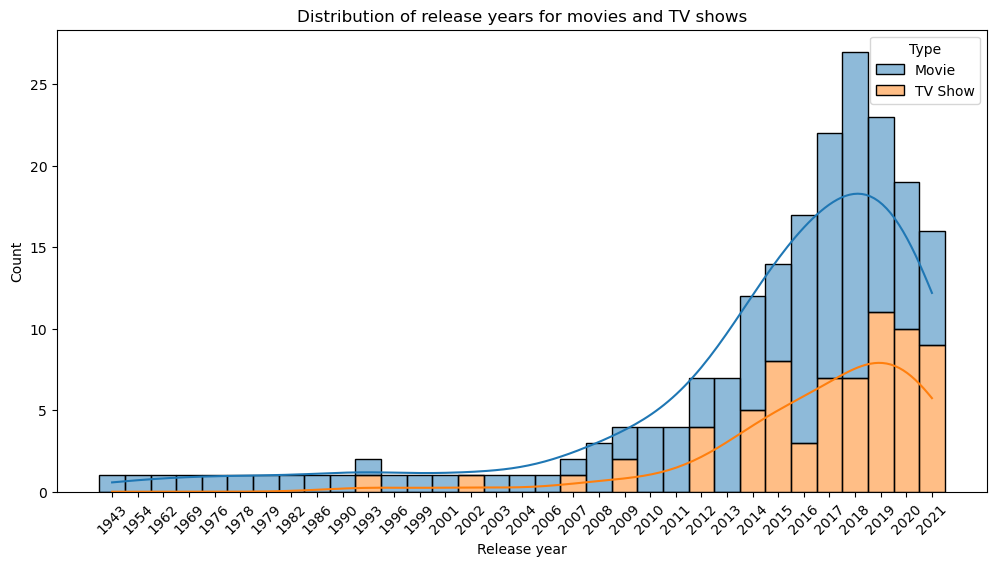

In [4]:
netflix_df_sorted = netflix_df.sort_values(by='Release year')

plt.figure(figsize=(12, 6))
sns.histplot(data=netflix_df_sorted, x='Release year', hue='Type', multiple='stack', bins=20, kde=True)
plt.title('Distribution of release years for movies and TV shows')
plt.xlabel('Release year')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

##### Countries with most content

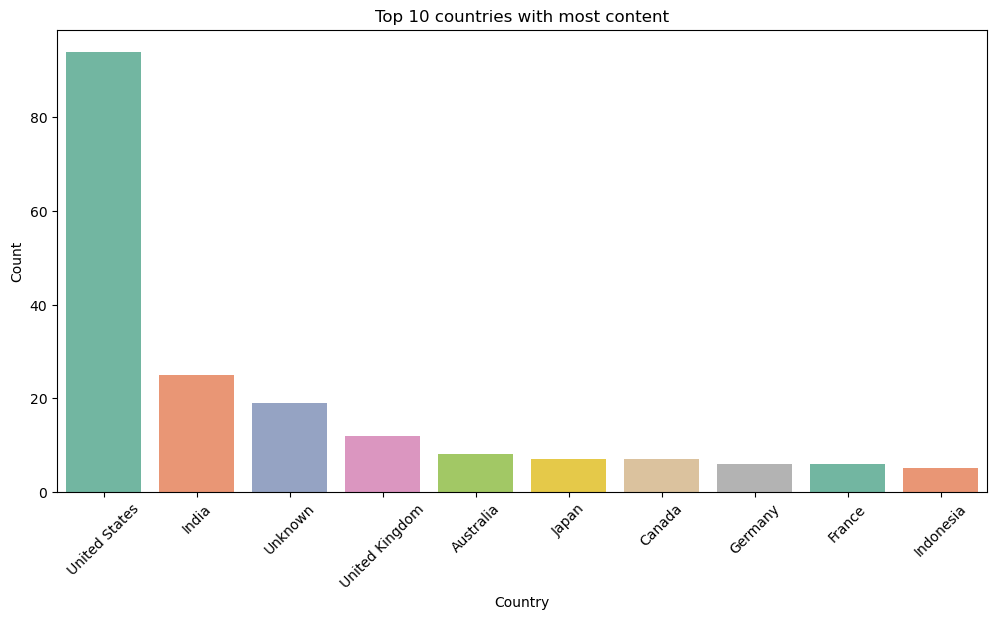

In [5]:
netflix_df_country_unknown = netflix_df.copy()
netflix_df_country_unknown['Country'] = netflix_df_country_unknown['Country'].replace('nan', 'Unknown')

# Count countries considering multiple countries per movie
countries_count = {}
for countries in netflix_df_country_unknown['Country'].str.split(', '):
    for country in countries:
        countries_count[country] = countries_count.get(country, 0) + 1
countries_df = pd.DataFrame.from_dict(countries_count, orient='index', columns=['Count'])
countries_df = countries_df.sort_values(by='Count', ascending=False).head(10)

# Plot the distribution of countries
plt.figure(figsize=(12, 6))
sns.barplot(x=countries_df.index, y=countries_df['Count'], palette='Set2')
plt.title('Top 10 countries with most content')
plt.xlabel('Country')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

### Question answering system

#### Load the pre-trained model and tokenizer

In [6]:
model_name = "bert-large-uncased-whole-word-masking-finetuned-squad"
qa_pipeline = pipeline('question-answering', model=model_name, tokenizer=model_name)

#### Generating questions

We generate questions for each row based on the attributes of the movie or TV show. 
The questions cover basic information such as title, description, director, cast, country, release year, duration, and rating. The questions directly address user needs and preferences.

In [7]:
# Generate questions for each row
def generate_questions(row):
    questions = []
    questions.append(f"What is {row['Title']} about?")
    questions.append(f"Who directed {row['Title']}?")
    questions.append(f"Who are the cast members of {row['Title']}?")
    questions.append(f"Where was {row['Title']} produced?")
    questions.append(f"When was {row['Title']} released?")
    if row['Type'] == 'Movie':
        questions.append(f"What is the duration of {row['Title']}?")
        questions.append(f"What is the rating of {row['Title']}?")
    else:
        questions.append(f"How many seasons does {row['Title']} have?")
        questions.append(f"What is the rating of {row['Title']}?")
    return questions

netflix_df['questions'] = netflix_df.apply(generate_questions, axis=1)

#### Answer retrieval

Finally, we get answers for each question using the question answering model.

In [8]:
# Get answers for each question
def get_answers(row):
    answers = []
    for question in row['questions']:
        answer = qa_pipeline(question=question, context=row['joined_text'])['answer']
        if answer == "nan":
            answer = "Unknown"
        answers.append(answer)
    return answers

netflix_df['answers'] = netflix_df.apply(get_answers, axis=1)

In [9]:
# Organize actual answers in one column
def get_actual_answers(row):
    actual_answers = []
    actual_answers.append(row['Description'])  # First question
    actual_answers.append(row['Director'])     # Second question
    actual_answers.append(row['Cast'])         # Third question
    actual_answers.append(row['Country'])      # Fourth question
    actual_answers.append(row['Release year']) # Fifth question
    actual_answers.append(row['Duration'])     # Sixth question
    actual_answers.append(row['Rating'])       # Seventh question
    return actual_answers

netflix_df['actual_answers'] = netflix_df.apply(get_actual_answers, axis=1)

### Evaluation metrics

This section focuses on computing metrics to evaluate the performance of the question-answering system, such as the percent of correct answers and cosine similarity scores.

In [10]:
# Compute percent of correct answers for each row
def percent_correct_answers(row):
    correct_count = 0
    for i, model_answer in enumerate(row['answers']):
        actual_answer = row['actual_answers'][i]
        if model_answer == actual_answer:
            correct_count += 1
        elif actual_answer=="nan" and model_answer=="Unknown":
            correct_count += 1
    return correct_count/7

netflix_df['percent_correct_answers'] = netflix_df.apply(percent_correct_answers, axis=1)

In [11]:
# Load the sentence transformer model
sentence_model = SentenceTransformer('sentence-transformers/distilbert-base-nli-stsb-mean-tokens')

# Compute cosine similarity between model answer and actual answer
def compute_cosine_similarity(row):
    similarities = []
    for i, model_answer in enumerate(row['answers']):
        actual_answer = row['actual_answers'][i]
        if model_answer == actual_answer:
            similarity = 1.0  # If answers are identical, set similarity to 1
        elif actual_answer=="nan" and model_answer=="Unknown":
            similarity = 1.0
        else:
            # Compute cosine similarity between embeddings of model and actual answers
            model_embedding = sentence_model.encode(model_answer)
            actual_embedding = sentence_model.encode(actual_answer)
            similarity = cosine_similarity([model_embedding], [actual_embedding])[0][0]
            # Normalize similarity between 0 and 1
            similarity = (similarity + 1) / 2
        similarities.append(similarity)
    return similarities

netflix_df['cosine_similarity'] = netflix_df.apply(compute_cosine_similarity, axis=1)
# Compute the sum of cosine similarity values for each row (normalized)
netflix_df['similarity_score'] = netflix_df['cosine_similarity'].apply(np.sum)/7

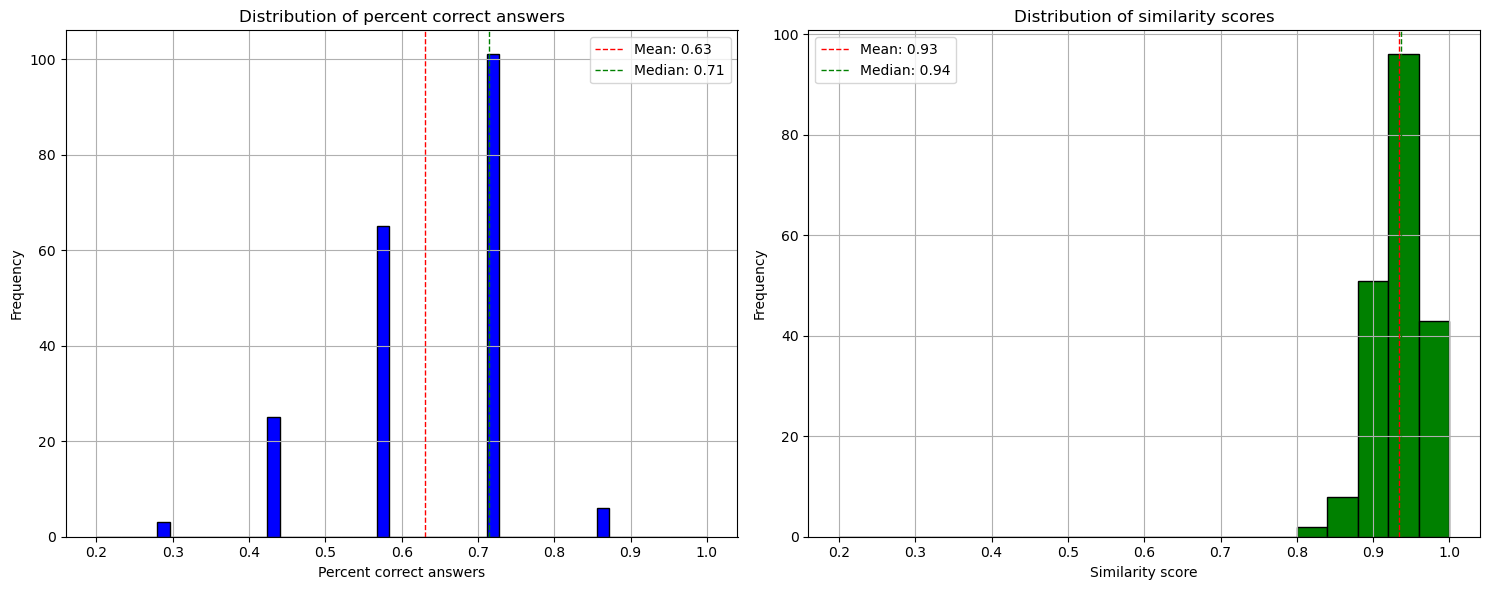

In [12]:
#Plot the metrics distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot distribution of percent correct answers
axes[0].hist(netflix_df['percent_correct_answers'], bins=50, range=(0.2, 1), color='blue', edgecolor='black')
axes[0].set_title('Distribution of percent correct answers')
axes[0].set_xlabel('Percent correct answers')
axes[0].set_ylabel('Frequency')
axes[0].grid(True)
mean_pc = netflix_df['percent_correct_answers'].mean()
median_pc = netflix_df['percent_correct_answers'].median()
axes[0].axvline(mean_pc, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean_pc:.2f}')
axes[0].axvline(median_pc, color='green', linestyle='dashed', linewidth=1, label=f'Median: {median_pc:.2f}')
axes[0].legend()

# Plot distribution of similarity score
axes[1].hist(netflix_df['similarity_score'], bins=20, range=(0.2, 1), color='green', edgecolor='black')
axes[1].set_title('Distribution of similarity scores')
axes[1].set_xlabel('Similarity score')
axes[1].set_ylabel('Frequency')
axes[1].grid(True)
mean_sim = netflix_df['similarity_score'].mean()
median_sim = netflix_df['similarity_score'].median()
axes[1].axvline(mean_sim, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean_sim:.2f}')
axes[1].axvline(median_sim, color='green', linestyle='dashed', linewidth=1, label=f'Median: {median_sim:.2f}')
axes[1].legend()

plt.tight_layout()
plt.show()

#### Sample analysis

Here, we compare model's answers with the actual answers. This allows for a qualitative assessment of the system's performance.

In [13]:
row_indices = [0, 2]

# Check answers obtained from the model with the actual data
for idx in row_indices:
    row = netflix_df.iloc[idx]
    print(f"\nTitle: {row['Title']}")
    print()
    for i, question in enumerate(row['questions']):
        print(f"Question {i+1}: {question}")
        print(f"Model's answer: {row['answers'][i]}")
        print(f"Actual answer: {row['actual_answers'][i]}")
        if row['answers'][i] == row['actual_answers'][i]:
            print("Answer is correct!")
        elif row['actual_answers'][i]=="nan" and row['answers'][i]=="Unknown":
            print("Answer is correct!")
        else:
            print("Answer is incorrect!")
        print()


Title: Game Over, Man!

Question 1: What is Game Over, Man! about?
Model's answer: Three buddies with big dreams
Actual answer: Three buddies with big dreams go from underachieving slackers to badass warriors when their posh hotel is taken over by terrorists.
Answer is incorrect!

Question 2: Who directed Game Over, Man!?
Model's answer: Kyle Newacheck
Actual answer: Kyle Newacheck
Answer is correct!

Question 3: Who are the cast members of Game Over, Man!?
Model's answer: Adam DeVine, Anders Holm
Actual answer: Adam DeVine, Anders Holm, Blake Anderson, Utkarsh Ambudkar, Aya Cash, Neal McDonough, Daniel Stern, Jamie Demetriou, Rhona Mitra, Sam Richardson, Steve Howey, Mac Brandt, Geno Segers, Roe Hartrampf
Answer is incorrect!

Question 4: Where was Game Over, Man! produced?
Model's answer: United States
Actual answer: United States
Answer is correct!

Question 5: When was Game Over, Man! released?
Model's answer: March 23, 2018. Release year: 2018
Actual answer: 2018
Answer is incorr

While mean percentage of correct answers (63% accuracy rate) indicates that the system correctly answered the majority of questions, there is still room for improvement to achieve higher accuracy levels. Additionally, the high mean similarity score (of 93%) suggests that the system's answers are semantically similar to the actual data in the majority of cases, indicating a good understanding of the context.

##### Future directions:
- Fine-tuning the model
- Expanding question types
- Exploring other models